<a href="https://colab.research.google.com/github/Iman-Kalyan-Majumder/Wine-Reviews/blob/main/freecodecamp_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


In [ ]:
df=pd.read_csv("wine-reviews.csv", usecols=['country','description','points','price','variety','winery'])

In [ ]:
df=df.dropna(subset=['description','points'])

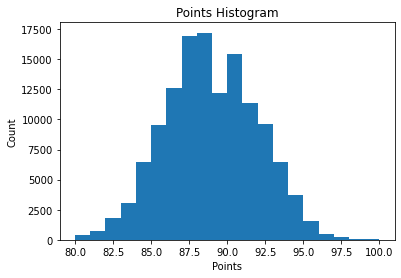

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.ylabel("Count")
plt.xlabel("Points")
plt.show()

In [ ]:
df['labels'] = (df['points']>=90).astype(int)
df = df[['description', 'labels']]
df

,description,labels
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1


In [ ]:
train , valid , test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

In [ ]:
len(train) , len(valid) , len(test)

(103976, 12997, 12998)

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('labels')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

Embedding + Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.2036931 , -0.20916663, -0.22185802, ...,  0.14878954,
         0.03212439,  0.20381814],
       [ 0.23278125, -0.06633104, -0.17852417, ...,  0.02808911,
        -0.25111333,  0.01553658],
       [ 0.40746903,  0.06025631,  0.00128878, ..., -0.3283891 ,
        -0.26708135, -0.08891766],
       ...,
       [ 0.38615206, -0.09016182,  0.16389412, ...,  0.03003385,
        -0.0570815 , -0.19644843],
       [ 0.18192737, -0.31532228, -0.00138672, ...,  0.04476616,
        -0.15146859,  0.03794404],
       [ 0.5734    , -0.15668012, -0.1963214 , ..., -0.15960333,
        -0.15062052,  0.12139287]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy']
)

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 7s 59ms/step - loss: 0.7387 - Accuracy: 0.3777


[0.7387195825576782, 0.37772178649902344]

In [ ]:
 model.evaluate(valid_data)

13/13 [==============================] - 1s 59ms/step - loss: 0.7386 - Accuracy: 0.3762


[0.7385956048965454, 0.3761637210845947]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 51s 495ms/step - loss: 0.6143 - Accuracy: 0.6650 - val_loss: 0.4623 - val_Accuracy: 0.8123
Epoch 2/5
102/102 [==============================] - 53s 519ms/step - loss: 0.4134 - Accuracy: 0.8130 - val_loss: 0.3868 - val_Accuracy: 0.8253
Epoch 3/5
102/102 [==============================] - 53s 512ms/step - loss: 0.3378 - Accuracy: 0.8552 - val_loss: 0.3972 - val_Accuracy: 0.8272
Epoch 4/5
102/102 [==============================] - 51s 497ms/step - loss: 0.3060 - Accuracy: 0.8746 - val_loss: 0.4093 - val_Accuracy: 0.8217
Epoch 5/5
102/102 [==============================] - 51s 499ms/step - loss: 0.2849 - Accuracy: 0.8870 - val_loss: 0.4315 - val_Accuracy: 0.8232


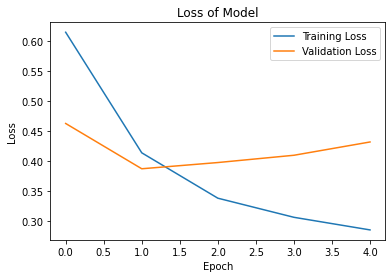

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 1s 87ms/step - loss: 0.4249 - Accuracy: 0.8217


[0.4248552918434143, 0.8216648697853088]

LSTM

In [ ]:
encode = tf.keras.layers.TextVectorization(max_tokens=2000)
encode.adapt(train_data.map(lambda text, label:text))

In [ ]:
vocab = np.array(encode.get_vocabulary())

In [ ]:
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
                             encode,
                             tf.keras.layers.Embedding(
                                 input_dim=len(encode.get_vocabulary()),
                                 output_dim=32,
                                 mask_zero=True
                             ),
                             tf.keras.layers.LSTM(32),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['Accuracy']
)

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 21s 178ms/step - loss: 0.6939 - Accuracy: 0.3981


[0.693902313709259, 0.39810147881507874]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 4s 304ms/step - loss: 0.6939 - Accuracy: 0.3959


[0.6938990950584412, 0.39586058259010315]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 68s 580ms/step - loss: 0.5482 - Accuracy: 0.7090 - val_loss: 0.3819 - val_Accuracy: 0.8304
Epoch 2/5
102/102 [==============================] - 49s 475ms/step - loss: 0.3709 - Accuracy: 0.8363 - val_loss: 0.3570 - val_Accuracy: 0.8387
Epoch 3/5
102/102 [==============================] - 50s 491ms/step - loss: 0.3493 - Accuracy: 0.8460 - val_loss: 0.3527 - val_Accuracy: 0.8377
Epoch 4/5
102/102 [==============================] - 49s 480ms/step - loss: 0.3432 - Accuracy: 0.8484 - val_loss: 0.3514 - val_Accuracy: 0.8399
Epoch 5/5
102/102 [==============================] - 49s 485ms/step - loss: 0.3381 - Accuracy: 0.8502 - val_loss: 0.3521 - val_Accuracy: 0.8408


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 4s 291ms/step - loss: 0.3500 - Accuracy: 0.8403


[0.3500085771083832, 0.8402830958366394]